In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

(no of image, height, width, 3 = RGB)

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder

def preprocess_images(images_dir, image_size=(299, 299)):
    X = []
    y = []
    class_dirs = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]
    for class_dir in class_dirs:
        class_label = class_dir
        image_files = [f for f in os.listdir(os.path.join(images_dir, class_dir)) if f.endswith('.jpg') or f.endswith('.png')]

        for filename in image_files:
            img = cv2.imread(os.path.join(images_dir, class_dir, filename))
            img = cv2.resize(img, image_size)
            img = img.astype(np.float32) / 255.0
            img_array = img_to_array(img)
            X.append(img_array)
            y.append(class_label)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    X = np.array(X)
    y = np.array(y)

    return X, y

train_dir = '/content/drive/MyDrive/Multi/Train'
test_dir = '/content/drive/MyDrive/Multi/Test'
X_train, y_train = preprocess_images(train_dir)
X_test, y_test = preprocess_images(test_dir)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2463, 299, 299, 3)
Shape of y_train: (2463,)
Shape of X_test: (1059, 299, 299, 3)
Shape of y_test: (1059,)


# Data splitting
70:30


```
import os
import shutil
import random

# Define the source directory containing the folders
source_dir = 'Images'

# Define the destination directories for train and test sets
train_dir = 'Train'
test_dir = 'Test'

# Ensure the destination folders exist; create them if they don't
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List of folders inside the source directory
folders = ['ALL', 'AML', 'CML', 'CLL', 'Healthy']

# Split each folder into train and test sets
for folder in folders:
    # Get the list of files in the current folder
    files = os.listdir(os.path.join(source_dir, folder))
    # Shuffle the list of files randomly
    random.shuffle(files)
    # Calculate the number of files for the training set (70%) and test set (30%)
    num_train = int(0.7 * len(files))
    num_test = len(files) - num_train
    # Move files to the train set
    for filename in files[:num_train]:
        source_file = os.path.join(source_dir, folder, filename)
        dest_file = os.path.join(train_dir, folder, filename)
        os.makedirs(os.path.dirname(dest_file), exist_ok=True)
        shutil.move(source_file, dest_file)
    # Move files to the test set
    for filename in files[num_train:]:
        source_file = os.path.join(source_dir, folder, filename)
        dest_file = os.path.join(test_dir, folder, filename)
        os.makedirs(os.path.dirname(dest_file), exist_ok=True)
        shutil.move(source_file, dest_file)

print("Files split into train and test sets successfully!")

```



# Compile the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

batch_size = 32
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers[:-5]:
    layer.trainable = False
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

87910968/87910968 [==============================] - 1s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

#Load the dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/Multi/Train'
test_dir = '/content/drive/MyDrive/Multi/Test'
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2463 images belonging to 5 classes.
Found 1059 images belonging to 5 classes.


# Model Training

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator
)

Epoch 1/5
77/77 [==============================] - 113s 1s/step - loss: 0.0067 - accuracy: 0.9976 - val_loss: 0.0181 - val_accuracy: 0.9934
Epoch 2/5
77/77 [==============================] - 100s 1s/step - loss: 0.0065 - accuracy: 0.9976 - val_loss: 0.0071 - val_accuracy: 0.9962
Epoch 3/5
77/77 [==============================] - 100s 1s/step - loss: 0.0055 - accuracy: 0.9980 - val_loss: 0.0079 - val_accuracy: 0.9962
Epoch 4/5
77/77 [==============================] - 101s 1s/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.0156 - val_accuracy: 0.9924
Epoch 5/5
77/77 [==============================] - 99s 1s/step - loss: 0.0103 - accuracy: 0.9959 - val_loss: 0.0105 - val_accuracy: 0.9953


In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator
)

Epoch 1/5
77/77 [==============================] - 99s 1s/step - loss: 0.0035 - accuracy: 0.9988 - val_loss: 0.0379 - val_accuracy: 0.9924
Epoch 2/5
77/77 [==============================] - 101s 1s/step - loss: 0.0073 - accuracy: 0.9963 - val_loss: 0.0240 - val_accuracy: 0.9943
Epoch 3/5
77/77 [==============================] - 101s 1s/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.0166 - val_accuracy: 0.9953
Epoch 4/5
77/77 [==============================] - 100s 1s/step - loss: 0.0029 - accuracy: 0.9984 - val_loss: 0.0071 - val_accuracy: 0.9972
Epoch 5/5
77/77 [==============================] - 108s 1s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9972


#Evaluate the model

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

34/34 [==============================] - 32s 941ms/step - loss: 0.0048 - accuracy: 0.9972
Test accuracy: 0.9971671104431152


# Evaluation Metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.9854378597721939
Recall: 0.9971494629946267
F1-score: 0.9905358762724435


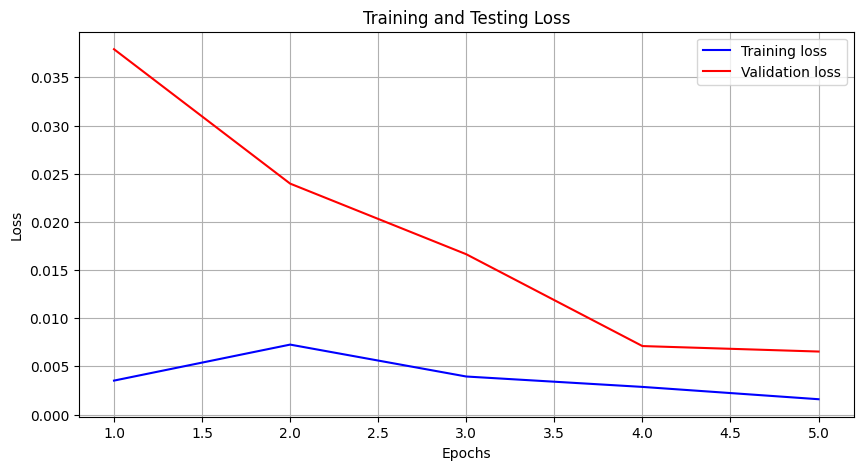

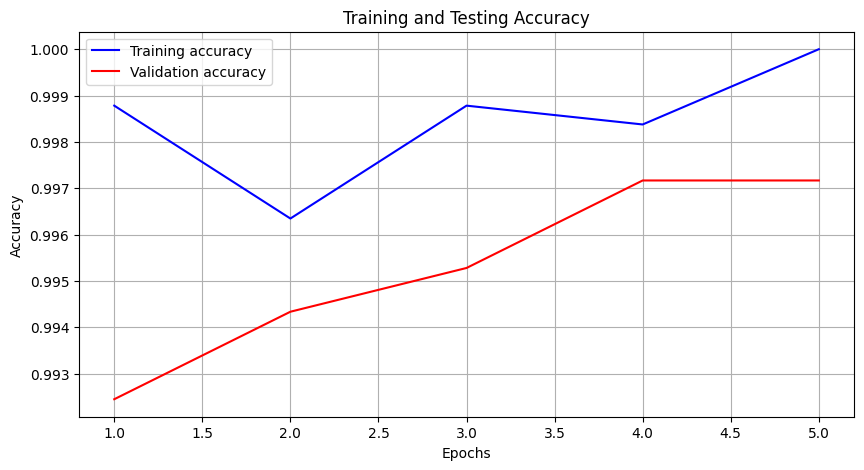

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Testing loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Testing accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

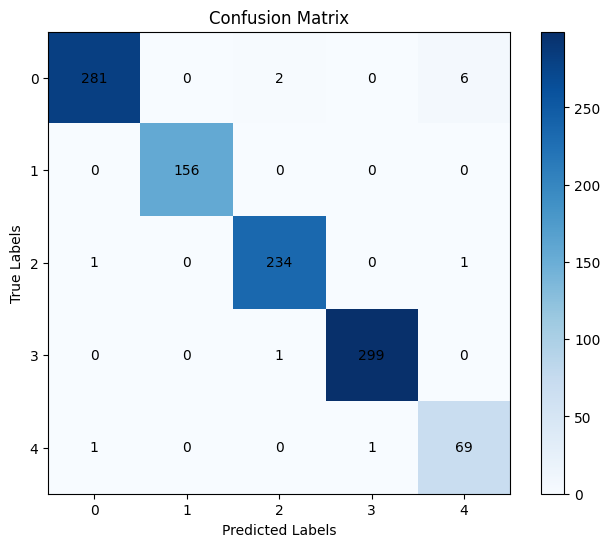

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

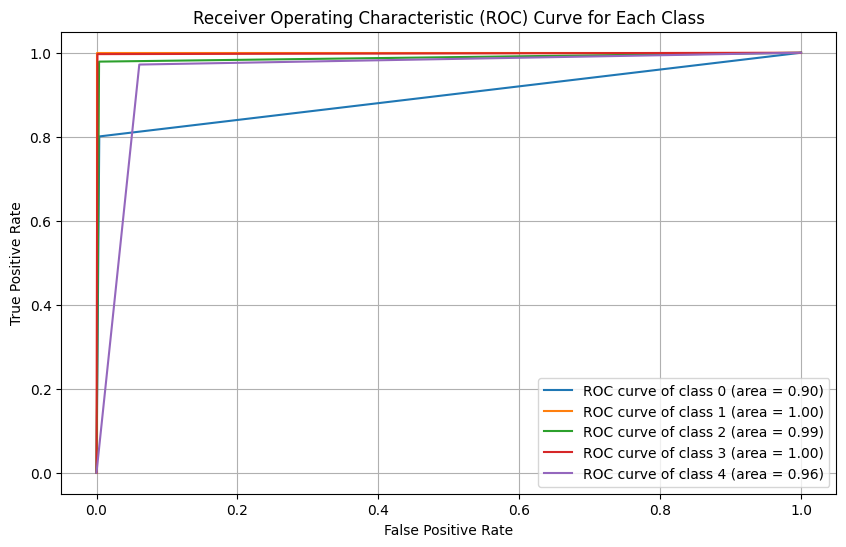

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

num_classes = 5
y_test_reshaped = np.eye(num_classes)[y_test.astype(int)]
y_pred_reshaped = np.eye(num_classes)[np.argmax(y_pred, axis=1)]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_reshaped[:, i], y_pred_reshaped[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 208ms/step
Predicted class: Healthy
Confidence score: 0.9999998807907104


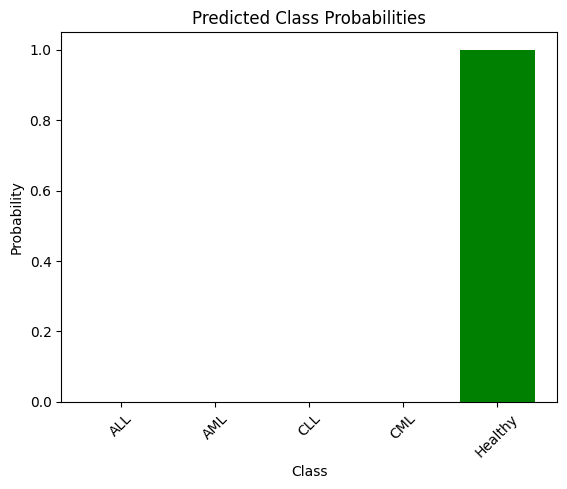

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/Multi/Test/Healthy/Healthy_127.jpg'
img = image.load_img(image_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
predictions = model.predict(img_array)
class_labels = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
predicted_class_label = class_labels[np.argmax(predictions)]
confidence_score = predictions[0][np.argmax(predictions)]
print(f'Predicted class: {predicted_class_label}')
print(f'Confidence score: {confidence_score}')
def plot_predicted_class_probabilities(probabilities, class_labels):
    plt.bar(class_labels, probabilities, color='green')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Predicted Class Probabilities')
    plt.xticks(rotation=45)
    plt.show()

plot_predicted_class_probabilities(predictions[0], class_labels)

1/1 [==============================] - 2s 2s/step
Predicted class: ALL
Confidence score: 1.0


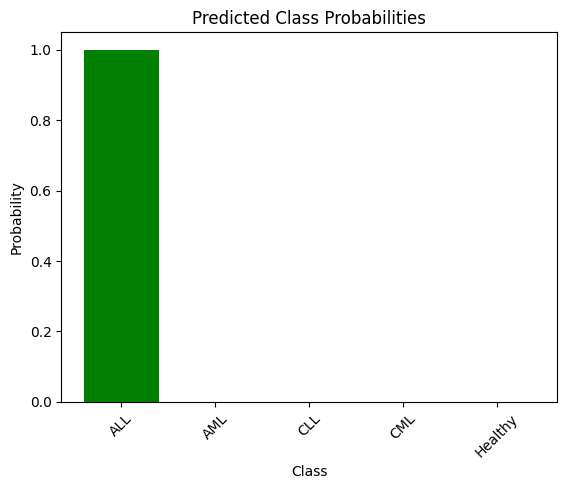

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/Multi/Test/ALL/ALL_141.jpg'
img = image.load_img(image_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
predictions = model.predict(img_array)
class_labels = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
predicted_class_label = class_labels[np.argmax(predictions)]
confidence_score = predictions[0][np.argmax(predictions)]
print(f'Predicted class: {predicted_class_label}')
print(f'Confidence score: {confidence_score}')
def plot_predicted_class_probabilities(probabilities, class_labels):
    plt.bar(class_labels, probabilities, color='green')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Predicted Class Probabilities')
    plt.xticks(rotation=45)
    plt.show()

plot_predicted_class_probabilities(predictions[0], class_labels)

1/1 [==============================] - 0s 406ms/step
Predicted class: AML
Confidence score: 1.0


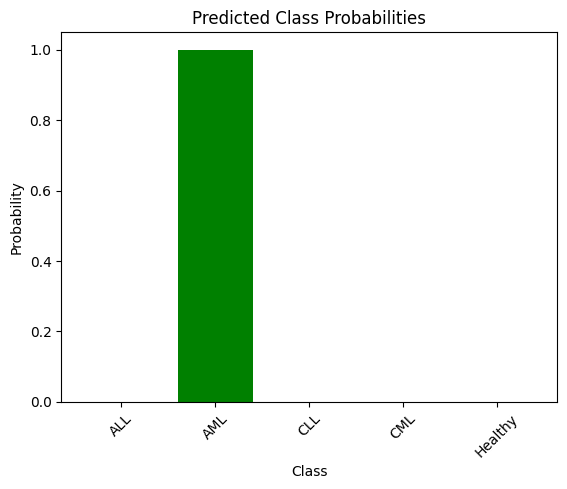

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/Multi/Test/AML/AML_158.jpg'
img = image.load_img(image_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
predictions = model.predict(img_array)
class_labels = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
predicted_class_label = class_labels[np.argmax(predictions)]
confidence_score = predictions[0][np.argmax(predictions)]
print(f'Predicted class: {predicted_class_label}')
print(f'Confidence score: {confidence_score}')
def plot_predicted_class_probabilities(probabilities, class_labels):
    plt.bar(class_labels, probabilities, color='green')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Predicted Class Probabilities')
    plt.xticks(rotation=45)
    plt.show()

plot_predicted_class_probabilities(predictions[0], class_labels)

1/1 [==============================] - 0s 227ms/step
Predicted class: CLL
Confidence score: 1.0


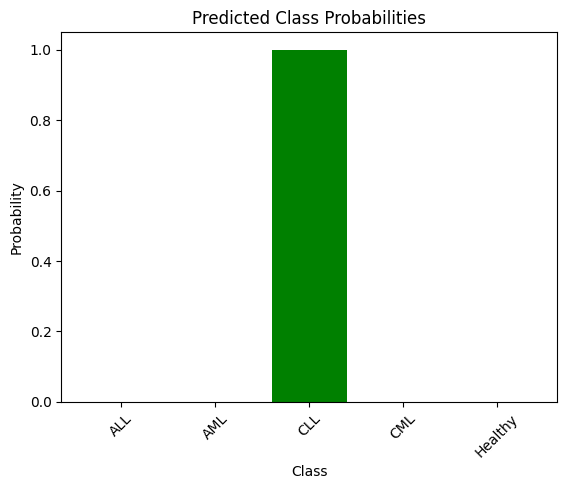

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/Multi/Test/CLL/CLL_132.jpg'
img = image.load_img(image_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
predictions = model.predict(img_array)
class_labels = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
predicted_class_label = class_labels[np.argmax(predictions)]
confidence_score = predictions[0][np.argmax(predictions)]
print(f'Predicted class: {predicted_class_label}')
print(f'Confidence score: {confidence_score}')
def plot_predicted_class_probabilities(probabilities, class_labels):
    plt.bar(class_labels, probabilities, color='green')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Predicted Class Probabilities')
    plt.xticks(rotation=45)
    plt.show()
plot_predicted_class_probabilities(predictions[0], class_labels)

1/1 [==============================] - 0s 226ms/step
Predicted class: CML
Confidence score: 1.0


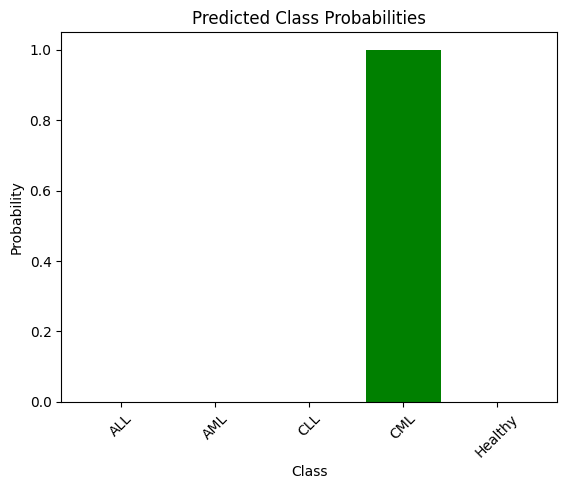

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

image_path = '/content/drive/MyDrive/Multi/Test/CML/cml test_original_20190121_143903.jpg_907bc34d-6ccf-43bc-b1a3-c8882b0c1bbd.jpg'
img = image.load_img(image_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
predictions = model.predict(img_array)
class_labels = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
predicted_class_label = class_labels[np.argmax(predictions)]
confidence_score = predictions[0][np.argmax(predictions)]
print(f'Predicted class: {predicted_class_label}')
print(f'Confidence score: {confidence_score}')
def plot_predicted_class_probabilities(probabilities, class_labels):
    plt.bar(class_labels, probabilities, color='green')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Predicted Class Probabilities')
    plt.xticks(rotation=45)
    plt.show()

plot_predicted_class_probabilities(predictions[0], class_labels)